Epoch 1/20
10/10 [==============================] - 3s 274ms/step - loss: 261906.1719 - constraint_learning: 133240.4688
Epoch 2/20
10/10 [==============================] - 2s 226ms/step - loss: 1903.5857 - constraint_learning: 1007.2252
Epoch 3/20
10/10 [==============================] - 3s 235ms/step - loss: 12276.4434 - constraint_learning: 1107.5808
Epoch 4/20
10/10 [==============================] - 3s 263ms/step - loss: 1727.6182 - constraint_learning: 291.5663
Epoch 5/20
10/10 [==============================] - 3s 239ms/step - loss: 387.5003 - constraint_learning: 121.6510
Epoch 6/20
10/10 [==============================] - 2s 219ms/step - loss: 936.5382 - constraint_learning: 111.3884
Epoch 7/20
10/10 [==============================] - 2s 213ms/step - loss: 1643.6492 - constraint_learning: 269.7904
Epoch 8/20
10/10 [==============================] - 2s 208ms/step - loss: 648.7967 - constraint_learning: 145.5053
Epoch 9/20
10/10 [==============================] - 2s 216ms/step -

<IPython.core.display.Javascript object>


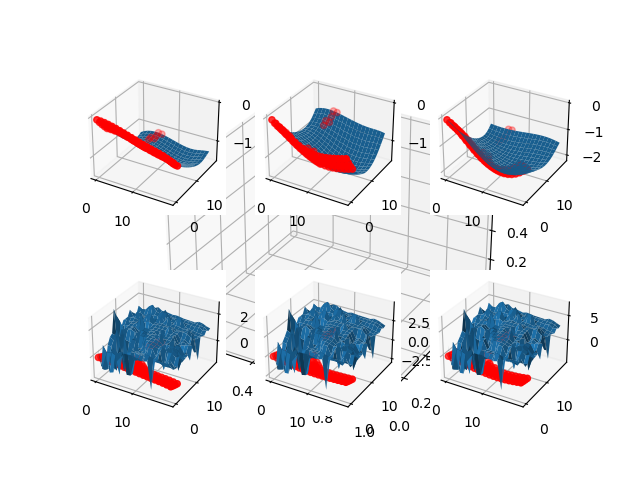

In [5]:
"""
    NN_RepresentativePoints_V4:
    
    This is the fourth attempt to "intelligently" decrease the resolution of images in a way that allows the original image
    to be reconstructed with minimal error. This is the first operational example. This version implements a proper generator
    as discussed in the previous version with an epoch function. 
    
    Overall, the code is modular and neat and effectively utilising the tensorflow tools. However, the model has a few 
    drawbacks. By randomly selecting the bottleneck parameter, the results are very variable (not stable). This makes
    the model difficult to train, which is evident by the model tending to select the highest elevation points in the 
    identifier, indicating that the identifier isn't learning to rank points, which is likely due to the interpolator 
    performing poorly (as the identifier depends on an interpolator that performs reasonably to be able to learn). 
    The clustering of points is also another issue, where the model isn't learning that selecting points close together
    has a lot of redundancy. 
    
    These problems are spatial problems, where the network has to learn how nodes are related spatially which is a challenge
    for a network to learn reliably. As a result, the outputs tend to be spikey, indicating that it also isn't learning that 
    points close together tend to have similar values. Additionally, this one is highly non-differentiable, which makes
    backpropogation more challenging.
    
    The model is still represented by: 
                                
    Identifier(data, bottlenecks):ranking 
                                        -> Selector(ranking, bottlenecks, data):representatives 
                                                                    -> Interpolator(representatives):reconstruction
    
    Pros:
        "Simple" implementation (quite modular)
        Guarantees compression rates (given by bottleneck)
        Easily adjustable
        Fast
        Generator allows training on synthesised data where real data is lacking
        Visualisation
        Each batched image can have a unique bottleneck
        Bottleneck value distribution is variable over epochs
        Spatially aware initialisation (removes symmetry in architecture)
    Cons:
        poor performance
        quite volatile (varying performance, need to be quite concerned with hyperparameters, especially with random bottleneck)
        dropouts not included
        Selector is non-differentiable (makes training more difficult, also can't employ tf.function for speed purposes)
        dense networks don't encode spatial information (result is spikey and takes time to learn (locally overfitting))
        Not able to reliably "compress" over compressions (fixed format)
        selection tends to be the highest values in the image, indicating the selector is performing poorly
        results are clustered together, indicating that the top-k model selects areas of interest rather than individual points
    """
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PerlinNoiseReduced as pn
import matplotlib.pyplot as plt
import os

# "solves" matplotlib issues
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib notebook

class Selector(keras.layers.Layer):
    """
    This is the layer responsible for selecting the points of the "bottleneck" largest values as produced by the 
    ranking of the Interpolator.
    
    Params:
        inputs(num_batches, image_size):          The ranking produced by Identifier
        bottleneck(num_batches, image_size):      The number of points to be selected
        data(num_batches, image_size):            The data points to select
    Outputs:
        representatives(num_batches, image_size): The points selected to represent the image
    """
    def build(self, input_shape):
        self.layer = keras.layers.Dense(units = input_shape[2][1], activation = tf.nn.relu, kernel_initializer = "identity")
    
    def call(self, inputs):
        inputs, bottleneck, data = inputs
        activation = self.layer(inputs)
        # select the largest inputs (corresponding to data points with the most information)
        indices = tf.RaggedTensor.from_tensor(tf.argsort(activation, direction = "DESCENDING"), bottleneck)
        indices = tf.RaggedTensor.with_row_splits_dtype(indices, tf.int32)
        inner_index = tf.RaggedTensor.from_row_lengths(tf.repeat(tf.range(data.shape[0]), bottleneck), bottleneck)
        indices = tf.cast(tf.reshape(tf.stack([inner_index, indices], axis = -1), (-1,2)), dtype = tf.int64)
        # we want the model to learn the dynamic bottleneck constraint so it can select the best points
        loss = 0.001*tf.reduce_mean(tf.square(tf.reduce_sum(activation, axis = -1)-tf.cast(bottleneck, tf.float32)))
        self.add_loss(loss)
        self.add_metric(loss, name = "constraint_learning")
        # return a sparse encoding
        return tf.SparseTensor(indices = indices, values = tf.gather_nd(data, indices), dense_shape = data.shape)
        
class Identifier(keras.layers.Layer):
    """
    This is the layer responsible for ranking which points are best for interpolation.
    
    Init:
        layer_units(list(int)):                   The size of each Dense layer
    Params:
        data(num_batches, image_size):            The data points to rank
        bottleneck(num_batches, image_size):      The number of points to be selected
    Outputs:
        representatives(num_batches, image_size): The points selected to represent the image
    """
    def __init__(self, layer_units):
        super(Identifier, self).__init__()
        self.layers = []
        for unit in layer_units:
            self.layers.append(keras.layers.Dense(units = unit, activation = tf.nn.relu, kernel_initializer = "identity"))
        self.selector = Selector()
            
    def call(self, inputs):
        data, bottleneck = inputs
        # give the model the bottleneck value to self learn bottleneck constraint
        activation = tf.concat([data, tf.cast(bottleneck[:,tf.newaxis], tf.float32)], axis = 1)
        for layer in self.layers:
            activation = layer(activation)
        return self.selector((activation, bottleneck, data))
    
class Interpolator(keras.layers.Layer):
    """
    This is the layer responsible for trying to interpolate between the representative points to reconstruct the image
    
    Init:
        layer_units(list(int)):                   The size of each Dense layer
    Params:
        inputs(num_batches, image_size):          The representative points
    Outputs:
        activation(num_batches, image_size):      The reconstructed image
    """
    def __init__(self, layer_units):
        super(Interpolator, self).__init__()
        self.layers = []
        for unit in layer_units:
            self.layers.append(keras.layers.Dense(units = unit, activation = tf.nn.relu, kernel_initializer = "identity"))
            #self.layers.append(keras.layers.Dropout(0))
        
    def build(self, original_shape):
        self.final = keras.layers.Dense(units = original_shape[1], kernel_initializer = "identity")
            
    def call(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        inputs = self.final(inputs)
        return inputs

def representative_points(identifier_units = [], interpolator_units = []):
    """
    The equivilent to the RepresentativePoints Model which inheriteded from Model below as done using the Sequential API.
    
    Init:
        identifier_units:                         The units for each layer in the identifier
        interpolator_units:                       The units for each layer in the interpolator
    Params:
        inputs(num_batches, image_size):          The image
    Outputs:
        model:                                    The constructed Sequential model
    """
    model = keras.models.Sequential()
    model.add(Identifier(identifier_units))
    model.add(Interpolator(identifier_units))
    return model

class RepresentativePoints(tf.keras.Model):
    """
    This is the Model combining the Identifier, Selector and Interpolator Layers.
    
    Init:
        identifier_units:                         The units for each layer in the identifier
        interpolator_units:                       The units for each layer in the interpolator
    Params:
        inputs(num_batches, image_size):          The image
    Outputs:
        interpolation(num_batches, image_size):   The reconstructed image
    """
    def __init__(self, identifier_units, interpolator_units):
        super(RepresentativePoints, self).__init__()
        self.identifier = Identifier(identifier_units)
        self.interpolator = Interpolator(identifier_units)
    
    def call(self, inputs, training = None):
        inputs = self.identifier(inputs)
        interpolation = self.interpolator(inputs)
        return interpolation if training else (inputs, interpolation)
        
class Generator(tf.keras.utils.Sequence):
    """
    A generator for data. This one generates it from the perlin noise generator and implements the epoch dependent 
    bottleneck generation to achieve the effect of the model starting with a large bottleneck so that the interpolator
    can learn how to recreate the image from all the points in the image. Gradually, the bottleneck value is decreased
    which results in the interpolator and identifier collectively learning how to reconstruct the image with fewer pixels
    (and accordingly select the most informative data points, after all, the identifier selects informative points based
    on how well the interpolator can use them to reconstrcut the image). This is done by randomly selecting a bottleneck
    value between the maximum number of pixels and some lower bound as a function of the current epoch.
    
    Init:
        image_shape:                              The shape of the output image
        max_epochs:                               The max number of epochs
        steps_per_epoch:                          How many training steps occur each epoch
        epoch_func:                               The lower bound on bottleneck as a function of the current epoch
        batch_size:                               The number of samples in a batch, defalulting to 32
    Outputs:
        ((images, bottlenecks),images):           A pair of training, testing results, where the training ones
                                                    are the input image and the desired number of representative 
                                                    points (bottleneck) and the testing one is the image to be 
                                                    used with mean squared error on the reconstructed image
    """
    def __init__(self, image_shape, max_epochs, steps_per_epoch, epoch_func = None, batch_size = 32):
        self.data_size = image_shape.prod()
        self.noise = pn.PerlinNoise(image_shape)
        self.current_epoch = 0
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        # default is a linear function, it starts with the maximum points and decreases linearly until the last epoch
        def linear(epoch):
            return 1-epoch/max_epochs
        self.epoch_func = linear if epoch_func is None else epoch_func
        self.batch_size = batch_size
        
    def __len__(self):
        return self.max_epochs*self.steps_per_epoch
    
    def __getitem__(self, step):
        images = np.zeros((self.batch_size, self.data_size))
        # this is some safety so that the number of pixels selected is some subset of what is in the image
        low = max(1, min(self.data_size, int(self.data_size*self.epoch_func(self.current_epoch))))
        # bottlenecks are determined randomly between the lower bound and maximum points
        bottlenecks = np.random.randint(low = low, high = self.data_size+1, size = self.batch_size)
        for b in range(self.batch_size):
            images[b] = self.noise.generate_fractal().flatten().flatten()
            # normalising for performance in neural network
            images[b] = images[b]/np.max(images[b])
            # as generate_fractal operates iteratively on a class variable, this resets it
            self.noise.reset()
        return ((images, bottlenecks),images)
    
    def on_epoch_end(self):
        self.current_epoch +=1

"""
    These are hyperparameters which are positioned together here for ease of change
    
    Variables:
        dim:                The dimension of the image
        BATCH_SIZE:         How many images are trained in parallel
        EPOCHS:             How many batches of images are used to train (~training steps)
        IDENTIFIER_UNITS:   The units for each layer in the identifier
        INTERPOLATOR_UNITS: The units for each layer in the interpolator
"""
        
dim = 20
image_shape = np.array((dim,dim))

BATCH_SIZE = 16
EPOCHS = 20
STEPS_PER_EPOCH = 10
IDENTIFIER_UNITS = [dim**2]
INTERPOLATOR_UNITS = [dim**2]

# initialising the model (both Sequential and inherited here)
#model = representative_points(identifier_units = IDENTIFIER_UNITS, interpolator_units = INTERPOLATOR_UNITS)
model = RepresentativePoints(identifier_units = IDENTIFIER_UNITS, interpolator_units = INTERPOLATOR_UNITS)
model.compile(optimizer = "Adam", loss = "mse", run_eagerly = True)

# fitting the data
data = Generator(image_shape, max_epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, batch_size = BATCH_SIZE)

model.fit(
    x=data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [],#[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
    steps_per_epoch=STEPS_PER_EPOCH)

#model.save("model.h5")

# visualisation of results
number = 3
noise = pn.PerlinNoise(image_shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(np.arange(0, image_shape[0]), np.arange(0, image_shape[1]))
for index in range(number):
    img = next(noise.generator()).flatten()
    reps, output = model((img[np.newaxis,:], np.array([100])), training = False)
    indices, reps = reps.indices[:,1], reps.values
    indices = np.take(np.stack(np.mgrid[:image_shape[0],:image_shape[1]], axis = -1).reshape(-1, 2), indices, axis = 0)
     
    ax = fig.add_subplot(2, number, index + 1, projection = "3d")
    #ax.set_zlim(bottom = -2)
    ax.plot_surface(x, y, img.reshape(image_shape))
    ax.scatter(indices[:,1], indices[:,0], reps, c = "r")
    
    ax = fig.add_subplot(2, number, number + index + 1, projection = "3d")
    #ax.set_zlim(bottom = -2)
    ax.plot_surface(x, y, np.array(output).reshape(image_shape))
    ax.scatter(indices[:,1], indices[:,0], reps, c = "r")